# Task 1: Introduction

---

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)

print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.
- Pandas return data as dataframe
- The data doesnot have names so we are giving names

In [2]:
df = pd.read_csv('data.csv', names = column_names)
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.
- isna() returns True or False for each column in each row. So it is not easy to look into all values.
- We use `sum()` to find the sum of each column.

In [3]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.
- Normalization is simply changing distribution of values of different features so that they are in similar ranges.

### Remove the unnecessary serial # column

In [4]:
df = df.iloc[:, 1:] #iloc[rows , columns] - for selecting datas of rows and columns 
#(similar to numpy)
# Here we have selected all rows of columns from 1 till the end

### Normalizing data using pandas

In [5]:
df_norm = (df - df.mean())/df.std() 
#This is done for each columns (mean and std also for each column) 
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [6]:
#Function to change value back when we get predicted price
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088)) #Checking our function

14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [7]:
x = df_norm.iloc[:, :-1] #Selecting Features (excluding price)
print(df_norm.head())
x.head()

       date       age  distance    stores  latitude  longitude     price
0  0.015978  0.181384  1.257002  0.345224 -0.307212  -1.260799  0.350088
1 -0.350485 -1.319118 -0.930610 -0.609312  0.325301  -1.260799 -1.836486
2  1.298598 -0.083410 -0.618094  0.663402  1.590328  -1.576456 -0.339584
3 -1.266643 -0.524735 -0.930610 -0.927491 -1.572238   0.948803 -1.839425
4  0.932135  0.534444  0.006938  0.981581 -1.255981  -0.945141  0.245266


,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [8]:
y = df_norm.iloc[:, -1:]
y.head()

,price
0,0.350088
1,-1.836486
2,-0.339584
3,-1.839425
4,0.245266


## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.
- Tensorflow is numpy compatible

In [9]:
#Converting Dataframe to numpyarray
x_arr = x.values
print(type(x_arr),type(x))
y_arr = y.values
print('Features array shape:', x_arr.shape)
print('Labels array shape:', y_arr.shape)

<class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>
Features array shape: (5000, 6)
Labels array shape: (5000, 1)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size = 0.05, random_state = 0)
print('Training set:', x_train.shape, y_train.shape)
print('Test set:', x_test.shape, y_test.shape)

Training set: (4750, 6) (4750, 1)
Test set: (250, 6) (250, 1)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.
- We will use a simple neural network with 3 hidden layers

In [11]:
def get_model():
    # We can pass the list of layers to Sequential class from keras to create a model architecture    
    model = Sequential([
        Dense(10, input_shape = (6,), activation='relu'), #1st Hidden layer - Dense layer with 10 nodes,relu - rectified linear unit
        Dense(20, activation='relu'), # A 2nd hidden dense layer with 20 nodes
        Dense(5, activation='relu'), # 3rd hidden layer
        Dense(1) # Ther output layer - Linear output without any activation
    ]) 
# Dense layers are fully connected layers

# Before we use a model we need to compile it with a loss function and optimizer
    model.compile(
        loss='mse',#Mean Square Error - Generally used in Regression problems
        optimizer='adam' # A algo to minimise the loss function
    )
    return model

get_model().summary() # To view the architecture of keras model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


#### To calculate the number of params
- \# of nodes * \# of output of previous layer + \# nodes in current layer (a bias param for each node)
Ex: dense_1 - 20 nodes * 10 outputs + 20 biased nodes = 220 params
for input layer - 10 nodes * 6 input + 10 biased nodes = 70 params

# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.
- we can use other params such as training loss or training accuracy, etc
- We can set the epoch value to high because the training stops after reaching our callback

In [12]:
es_cb = EarlyStopping(monitor='val_loss', patience=5) # Wait for 5 epochs before stopping

model = get_model() # Creating our model
preds_on_untrained = model.predict(x_test) # Untrained model will give random predictions

history = model.fit( #fit() to train model (essentially fit model on our data) and it returns history
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 100,
    callbacks = [es_cb] # can use list of callbacks
)
#The history object contains information on loss, validation loss across epochs

Train on 4750 samples, validate on 250 samples
Epoch 1/100
4750/4750 [==============================] - 1s 128us/sample - loss: 0.7740 - val_loss: 0.4335
Epoch 2/100
4750/4750 [==============================] - 0s 51us/sample - loss: 0.3941 - val_loss: 0.1751
Epoch 3/100
4750/4750 [==============================] - 0s 46us/sample - loss: 0.2004 - val_loss: 0.1593
Epoch 4/100
4750/4750 [==============================] - 0s 37us/sample - loss: 0.1783 - val_loss: 0.1560
Epoch 5/100
4750/4750 [==============================] - 0s 38us/sample - loss: 0.1702 - val_loss: 0.1553
Epoch 6/100
4750/4750 [==============================] - 0s 37us/sample - loss: 0.1655 - val_loss: 0.1534
Epoch 7/100
4750/4750 [==============================] - 0s 37us/sample - loss: 0.1637 - val_loss: 0.1494
Epoch 8/100
4750/4750 [==============================] - 0s 37us/sample - loss: 0.1622 - val_loss: 0.1481
Epoch 9/100
4750/4750 [==============================] - 0s 38us/sample - loss: 0.1606 - val_loss: 0.146

#### After 18th Epoch there is no improvement for 5 Epochs continuously so the training stops

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

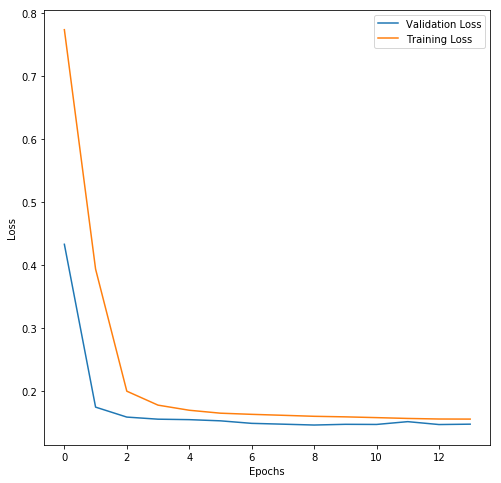

In [13]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

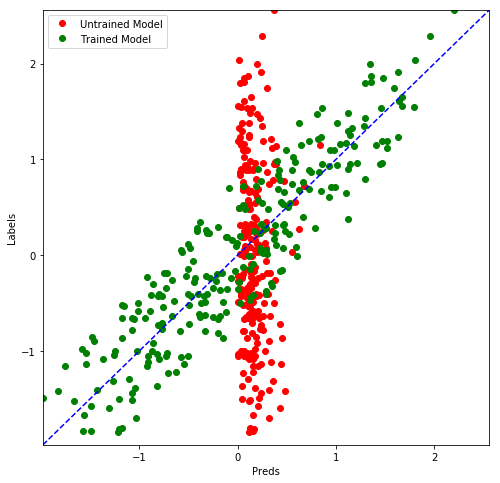

In [14]:
preds_on_trained = model.predict(x_test)
compare_predictions(preds_on_untrained, preds_on_trained, y_test)

#### Predicitons are in the range of normalized values

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

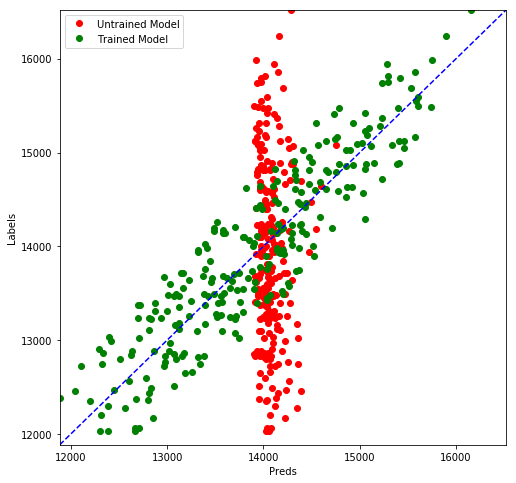

In [15]:
price_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_trained = [convert_label_value(y) for y in preds_on_trained]
price_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_untrained, price_trained, price_test)

### What we've learned:
- Approach and solve regression problems with neural networks using tensorflow and keras
- Little bit of pandas and normalization
- Use helper functions from sci-kit learn to split data
- Use of callbacks